In [1]:
import os 
from dotenv import load_dotenv, find_dotenv
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In this notebook, I explore the sample fire dispatch data provided to HACK OR Emergency Response Project Team. After looking at the distribution of timedesc_id types, I explore the time deltas between response steps for a given incident (ie time between dispatch to on-scene).

In [4]:
# walk root diretory to find and load .env file w/ AWS host, username and password
load_dotenv(find_dotenv())

True

In [5]:
# connect to postgres
def pgconnect():
    try:
        conn = psycopg2.connect(database=os.environ.get("erdatabase"), user=os.environ.get("eruser"), 
                            password = os.environ.get("erpassword"), 
                            host=os.environ.get("erhost"), port=os.environ.get("erport"))
        print("Opened database successfully")
        return conn
    
    except psycopg2.Error as e:
        print("I am unable to connect to the database")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

In [6]:
def pquery(QUERY):
    '''
    takes SQL query string, opens a cursor, and executes query in psql
    '''
    conn = pgconnect()
    
    if conn is None:
        return None
    
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)

    except Exception as e:
        print(e.pgerror)
        
    finally:
        conn.close()


In [7]:
# look at inctimes table first
QUERY1='''
SELECT inctimes_id, timedesc_id, incident_id, realtime,
 EXTRACT(DOW FROM realtime) AS dow,
 EXTRACT(MONTH FROM realtime) AS month,
 EXTRACT(YEAR FROM realtime) AS year
FROM inctimes;
'''

In [8]:
df1 = pquery(QUERY1)

SQL QUERY = 
SELECT inctimes_id, timedesc_id, incident_id, realtime,
 EXTRACT(DOW FROM realtime) AS dow,
 EXTRACT(MONTH FROM realtime) AS month,
 EXTRACT(YEAR FROM realtime) AS year
FROM inctimes;



In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1637845 entries, 0 to 1637844
Data columns (total 7 columns):
inctimes_id    1637845 non-null int64
timedesc_id    1637845 non-null int64
incident_id    1637845 non-null int64
realtime       1637845 non-null datetime64[ns]
dow            1637845 non-null float64
month          1637845 non-null float64
year           1637845 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 87.5 MB


In [10]:
df1.head(15)

,inctimes_id,timedesc_id,incident_id,realtime,dow,month,year
0,16517853,1,1102989,2014-09-22 08:33:03,1.0,9.0,2014.0
1,16517854,2,1102989,2014-09-22 08:34:16,1.0,9.0,2014.0
2,16517855,3,1102989,2014-09-22 08:34:33,1.0,9.0,2014.0
3,16519204,3,1102989,2014-09-22 08:34:33,1.0,9.0,2014.0
4,16926180,3,1102989,2015-01-19 10:29:50,1.0,1.0,2015.0
5,16517856,4,1102989,2014-09-22 08:35:41,1.0,9.0,2014.0
6,16519205,4,1102989,2014-09-22 08:35:41,1.0,9.0,2014.0
7,16517857,5,1102989,2014-09-22 08:42:43,1.0,9.0,2014.0
8,16519206,5,1102989,2014-09-22 08:42:43,1.0,9.0,2014.0
9,16517858,7,1102989,2014-09-22 08:56:03,1.0,9.0,2014.0


In [11]:
# Let's audit the data for duplicates where inctimes_id and timedesc_id are the same. 
# This code shows all rows that have a duplicate pair of incident_id, timedesc_id

df1.duplicated(['incident_id','timedesc_id'],keep = False).head(25)

0     False
1     False
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9     False
10     True
11     True
12    False
13    False
14    False
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23    False
24    False
dtype: bool

In [12]:
# print only rows where a duplicate incident_id/timedesc_id pair exists
df1[df1.duplicated(['incident_id','timedesc_id'],keep = False)]

,inctimes_id,timedesc_id,incident_id,realtime,dow,month,year
2,16517855,3,1102989,2014-09-22 08:34:33,1.0,9.0,2014.0
3,16519204,3,1102989,2014-09-22 08:34:33,1.0,9.0,2014.0
4,16926180,3,1102989,2015-01-19 10:29:50,1.0,1.0,2015.0
5,16517856,4,1102989,2014-09-22 08:35:41,1.0,9.0,2014.0
6,16519205,4,1102989,2014-09-22 08:35:41,1.0,9.0,2014.0
7,16517857,5,1102989,2014-09-22 08:42:43,1.0,9.0,2014.0
8,16519206,5,1102989,2014-09-22 08:42:43,1.0,9.0,2014.0
10,16519207,12,1102989,2014-09-22 08:56:03,1.0,9.0,2014.0
11,16926181,12,1102989,2015-01-19 10:29:55,1.0,1.0,2015.0
15,16518108,3,1102990,2014-09-22 08:51:13,1.0,9.0,2014.0


Looking at the duplicates above, it seems that the first row is more likely to be the "correct" one. Some events have duplicate timestamps for timedesc_id that are not even in the same year as the first entry, which seems unlikely. For purposes if this analysis, I will treat the first instance of the timedesc_id as correct and ignore the other duplicates. **However, this merits further discussion with the data people at PF&R and more investigation should be made into why duplicates occur and what they might mean.**

In [13]:
# this code does that (showing only first 25 rows)
df1[df1.duplicated(['incident_id','timedesc_id'],keep = 'first') == False].head(25)

,inctimes_id,timedesc_id,incident_id,realtime,dow,month,year
0,16517853,1,1102989,2014-09-22 08:33:03,1.0,9.0,2014.0
1,16517854,2,1102989,2014-09-22 08:34:16,1.0,9.0,2014.0
2,16517855,3,1102989,2014-09-22 08:34:33,1.0,9.0,2014.0
5,16517856,4,1102989,2014-09-22 08:35:41,1.0,9.0,2014.0
7,16517857,5,1102989,2014-09-22 08:42:43,1.0,9.0,2014.0
9,16517858,7,1102989,2014-09-22 08:56:03,1.0,9.0,2014.0
10,16519207,12,1102989,2014-09-22 08:56:03,1.0,9.0,2014.0
12,16518089,0,1102990,2014-09-22 08:49:54,1.0,9.0,2014.0
13,16518106,1,1102990,2014-09-22 08:50:08,1.0,9.0,2014.0
14,16518107,2,1102990,2014-09-22 08:50:56,1.0,9.0,2014.0


In [14]:
df1_nd = df1[df1.duplicated(['incident_id','timedesc_id'],keep = 'first') == False]

In [15]:
# after eliminating duplicates, what does the distribution of timedesc_ids look like?
df1_nd.groupby('timedesc_id')['timedesc_id'].count()

timedesc_id
0      62106
1     107268
2     107269
3     107271
4     105971
5     101551
7     107241
8      42712
9      56890
10     57321
11         2
12    105770
13      7149
Name: timedesc_id, dtype: int64

In [16]:
# after eliminating duplicates, what does the distribution of timedesc_ids look like?
pd.crosstab(index='count', columns=df1_nd['timedesc_id'])

timedesc_id,0,1,2,3,4,5,7,8,9,10,11,12,13
row_0,,,,,,,,,,,,,
count,62106,107268,107269,107271,105971,101551,107241,42712,56890,57321,2,105770,7149


In [17]:
# same crosstab data as a %
tab_norm = pd.crosstab(index='count', columns=df1_nd['timedesc_id']).apply(lambda r: r/r.sum(), axis=1)
tab_norm

timedesc_id,0,1,2,3,4,5,7,8,9,10,11,12,13
row_0,,,,,,,,,,,,,
count,0.064125,0.110754,0.110755,0.110758,0.109415,0.104852,0.110727,0.0441,0.058739,0.059184,0.000002,0.109208,0.007381


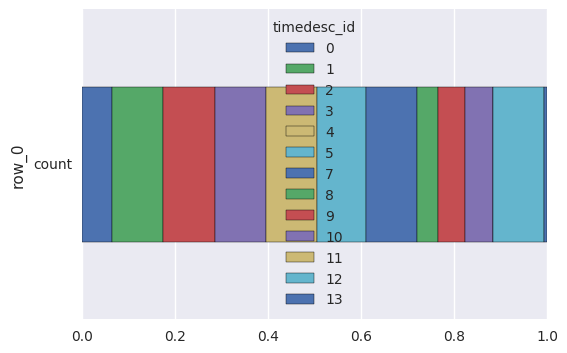

In [18]:
tab_norm.plot.barh(stacked = True)

From the summary statisics and stacked barplot, (and after removal of duplicates), we see some possibly interesting things regarding counts of each timedesc_id
* there are no timedesc_id events labeled 6 (Fire under control)
* timedesc_id events 1, 2, 3, 4, 5, 7, 12 all have fairly similar frequency of occurence ~10-11%
* why does 11 (depart desination) occur so infrequently?

Next, I look at distribution of response times. For sake of brevity, I initially look only at the time deltas between timedesc_id 3-5 (dispatch to on-scene) and 3-10 (disptach to arrive-destination).

In [19]:
# this function calculates time deltas for each incident id in the df
# iterating over the groupby object was very helpful

def time_delta(dataframe):
    '''caluclates the time delta between two different timedesc_ids for all groups'''
    count = 0
    group_dict = {}
    for name, group in dataframe.groupby('incident_id'):
        delta_dict = {}
        #print(name)
        #print(group)
        df_t = group.set_index('timedesc_id') # reset the group df to index on timedesc_id

        try:
            delta_dict['delta3-5'] = df_t.loc[5,'realtime']-df_t.loc[3,'realtime']
            delta_dict['dow'] = df_t.loc[3,'dow']
            delta_dict['month'] = df_t.loc[3,'month']
            
        except KeyError:
            delta_dict['delta3-5'] = None
            
        try:
            delta_dict['delta3-10'] =  df_t.loc[10,'realtime']-df_t.loc[3,'realtime']
            
        except KeyError:
            delta_dict['delta3-10'] = None   
        
        group_dict[name] = delta_dict        

    return group_dict
     

In [20]:
# use DataFrame.from_dict method to convert the dictionary object returned in the time_delta function to 
# a pandas df. Note using argument: orient = 'index' makes the dictionary keys into column headers.

#print(time_delta(df1_nd))
time_delta_df = pd.DataFrame.from_dict(time_delta(df1_nd), orient = 'index')
time_delta_df.index.name = 'incident_id'
time_delta_df.head(100)

,month,dow,delta3-10,delta3-5
incident_id,,,,
1102989,9.0,1.0,NaT,00:08:10
1102990,9.0,1.0,00:33:37,00:04:51
1102991,9.0,1.0,00:25:31,00:04:30
1102992,9.0,1.0,NaT,00:07:04
1102993,9.0,1.0,NaT,00:03:10
1102994,9.0,1.0,00:47:55,00:04:30
1102995,9.0,1.0,NaT,00:03:10
1102996,9.0,1.0,NaT,00:04:07
1102997,9.0,1.0,NaT,00:04:37


In [21]:
time_delta_df.describe()

,month,dow,delta3-10,delta3-5
count,101551.000000,101551.000000,57321,101551
mean,7.471034,3.039419,0 days 00:37:39.478166,0 days 00:05:49.396332
std,3.484812,1.987889,0 days 00:11:50.205399,0 days 02:36:51.456424
min,1.000000,0.000000,-1 days +23:39:35,-1 days +14:33:55
25%,5.000000,1.000000,0 days 00:29:24,0 days 00:03:35
50%,8.000000,3.000000,0 days 00:36:19,0 days 00:04:39
75%,11.000000,5.000000,0 days 00:44:11,0 days 00:05:56
max,12.000000,6.000000,0 days 05:51:26,32 days 06:23:57


In [22]:
'''
I noticed there are some negative timedelta values which are obviously impossible and should be thrown out.
In addition, pandas cannot plot histgram by just using: time_delta_df.plot()
So we need to do some timedelta conversion to a more easily plotted numerical type.
My approach was to convert the deltas to decimal expression of minutes. This link was helpful:
http://www.datasciencebytes.com/bytes/2015/05/16/pandas-timedelta-histograms-unit-conversion-and-overflow-danger/
'''
print(time_delta_df['delta3-5'].dropna() / pd.Timedelta(minutes=1)) # note that I dropped missing values from the time_delta_df

incident_id
1102989      8.166667
1102990      4.850000
1102991      4.500000
1102992      7.066667
1102993      3.166667
1102994      4.500000
1102995      3.166667
1102996      4.116667
1102997      4.616667
1102998      3.633333
1102999      6.583333
1103000      6.383333
1103001      5.650000
1103002      6.983333
1103003      4.250000
1103004      6.950000
1103005      2.983333
1103006     10.200000
1103007      5.033333
1103008      1.816667
1103009      6.316667
1103010      4.583333
1103011      4.400000
1103012      4.666667
1103013      4.216667
1103014      5.350000
1103016      2.616667
1103017      3.266667
1103018      4.683333
1103019      7.700000
              ...    
1210353      4.733333
1210354      4.950000
1210355      5.533333
1210356      6.016667
1210357      4.200000
1210358      3.166667
1210359      2.083333
1210360     12.066667
1210361     14.283333
1210362      3.233333
1210363     16.233333
1210364      4.416667
1210365      5.566667
1210366      7.33333

In [23]:
# remove null and negative values
# this link was helpful: http://stackoverflow.com/questions/24214941/python-pandas-dataframe-filter-negative-values
clean3_5 = time_delta_df[time_delta_df.loc[:,'delta3-5'] > 
                         pd.Timedelta(0)].loc[:,'delta3-5'].dropna()/pd.Timedelta(minutes=1)
clean3_10 = time_delta_df[time_delta_df.loc[:,'delta3-10'] > 
                         pd.Timedelta(0)].loc[:,'delta3-10'].dropna()/pd.Timedelta(minutes=1)

In [24]:
clean3_5.describe()

count    99614.000000
mean         5.948698
std        158.360530
min          0.016667
25%          3.650000
50%          4.700000
75%          5.966667
max      46463.950000
Name: delta3-5, dtype: float64

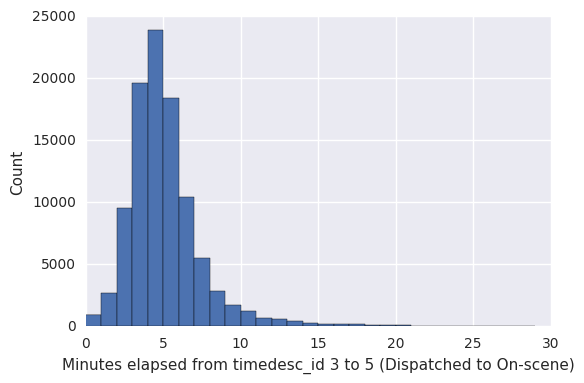

In [25]:
clean3_5.hist(bins=range(0,30,1))
plt.xlabel('Minutes elapsed from timedesc_id 3 to 5 (Dispatched to On-scene)')
plt.ylabel('Count')

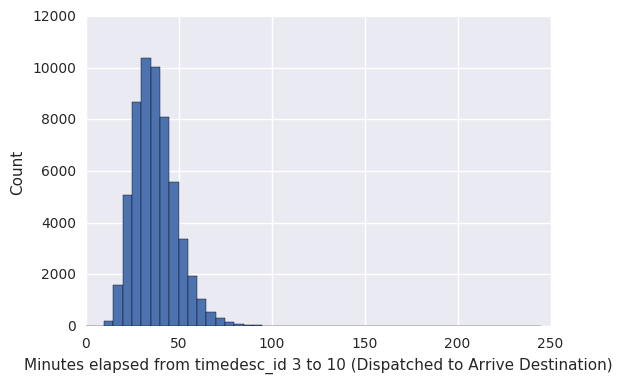

In [26]:
clean3_10.hist(bins=range(0,250,5))
plt.xlabel('Minutes elapsed from timedesc_id 3 to 10 (Dispatched to Arrive Destination)')
plt.ylabel('Count')

In [27]:
clean3_10.describe()

count    57316.000000
mean        37.662468
std         11.827266
min          0.416667
25%         29.400000
50%         36.316667
75%         44.183333
max        351.433333
Name: delta3-10, dtype: float64

From the histogram and summary statistics above, we can see that the mean response time between dispatch and on-scene is around 7.5 minutes.

For dispatch to arrival destination, the mean time delta is much longer, at 37.8 minutes. 

Both distributions appear normal, and are right skewed which is somewhat expected since outliers cannot exist below 0.

**_1/10/17 Next, if warranted, I can rebuild a summary dataframe with additional time deltas, not just between events 3-5 or 3-10. Not all timedelta pairs can be calculated for each incident id due to missing data, however. We can also look at the data tables to see types of dispatches and what their makeup is._**

In fact, boxplots to look at response time in different months, years and by other possibly interesting criteria would be good.

In [28]:
time_delta_df.head(10)

,month,dow,delta3-10,delta3-5
incident_id,,,,
1102989,9.0,1.0,NaT,00:08:10
1102990,9.0,1.0,00:33:37,00:04:51
1102991,9.0,1.0,00:25:31,00:04:30
1102992,9.0,1.0,NaT,00:07:04
1102993,9.0,1.0,NaT,00:03:10
1102994,9.0,1.0,00:47:55,00:04:30
1102995,9.0,1.0,NaT,00:03:10
1102996,9.0,1.0,NaT,00:04:07
1102997,9.0,1.0,NaT,00:04:37


In [29]:
# clean time_delta_df of negative times values and Nulls
time_delta_clean310 = time_delta_df[time_delta_df.loc[:,'delta3-10'] > 
                         pd.Timedelta(0)]

time_delta_clean310.head(10)

,month,dow,delta3-10,delta3-5
incident_id,,,,
1102990,9.0,1.0,00:33:37,00:04:51
1102991,9.0,1.0,00:25:31,00:04:30
1102994,9.0,1.0,00:47:55,00:04:30
1102998,9.0,1.0,00:41:58,00:03:38
1103001,9.0,1.0,00:18:08,00:05:39
1103003,9.0,1.0,00:32:16,00:04:15
1103004,9.0,1.0,00:24:34,00:06:57
1103005,9.0,1.0,00:53:43,00:02:59
1103007,9.0,1.0,00:27:20,00:05:02


In [30]:
# summary stats for 3-10 response time of each day of week
time_delta_clean310.groupby('dow')['dow', 'delta3-10'].describe()

dow               delta3-10
dow                                      
0.0 count  7801.0                    7801
    mean      0.0  0 days 00:36:20.069862
    std       0.0  0 days 00:11:08.100805
    min       0.0         0 days 00:05:36
    25%       0.0         0 days 00:28:37
    50%       0.0         0 days 00:35:11
    75%       0.0         0 days 00:42:26
    max       0.0         0 days 02:27:25
1.0 count  8271.0                    8271
    mean      1.0  0 days 00:37:52.637286
    std       0.0  0 days 00:11:38.116841
    min       1.0         0 days 00:06:47
    25%       1.0  0 days 00:29:39.500000
    50%       1.0         0 days 00:36:38
    75%       1.0         0 days 00:44:29
    max       1.0         0 days 02:10:54
2.0 count  8087.0                    8087
    mean      2.0  0 days 00:37:50.843823
    std       0.0  0 days 00:11:53.737977
    min       2.0         0 days 00:00:25
    25%       2.0  0 days 00:29:25.500000
    50%       2.0         0 days 00:36:30
    75%       2.0  0 days 00:44:33.500000
    max       2.0         0 days 02:33:05
3.0 count  8218.0                    8218
    mean      3.0  0 days 00:38:04.652591
    std       0.0  0 days 00:12:03.930203
    min       3.0         0 days 00:07:08
    25%       3.0         0 days 00:29:39
    50%       3.0  0 days 00:36:36.500000
    75%       3.0  0 days 00:44:47.750000
    max       3.0         0 days 03:34:43
4.0 count  8378.0                    8378
    mean      4.0  0 days 00:38:19.788135
    std       0.0  0 days 00:12:24.902209
    min       4.0         0 days 00:06:26
    25%       4.0         0 days 00:29:47
    50%       4.0  0 days 00:36:49.500000
    75%       4.0         0 days 00:44:56
    max       4.0         0 days 05:51:26
5.0 count  8385.0                    8385
    mean      5.0  0 days 00:38:31.425641
    std       0.0  0 days 00:12:07.559420
    min       5.0         0 days 00:10:35
    25%       5.0         0 days 00:29:58
    50%       5.0         0 days 00:37:02
    75%       5.0         0 days 00:45:17
    max       5.0         0 days 02:53:48
6.0 count  8159.0                    8159
    mean      6.0  0 days 00:36:33.169138
    std       0.0  0 days 00:11:12.930008
    min       6.0         0 days 00:02:49
    25%       6.0         0 days 00:28:37
    50%       6.0         0 days 00:35:22
    75%       6.0         0 days 00:42:54
    max       6.0         0 days 02:59:17

In [31]:
# try mapping numbers to strings for days of the week
# this was helpful: http://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict
dow_map = {0.0:'sunday',
           1.0:'monday', 
           2.0:'tuesday', 
           3.0:'wednesday', 
           4.0:'thursday', 
           5.0:'friday', 
           6.0:'saturday'}

td310_mapped = time_delta_clean310.replace({'dow':dow_map}).groupby('dow')['dow', 'delta3-10']


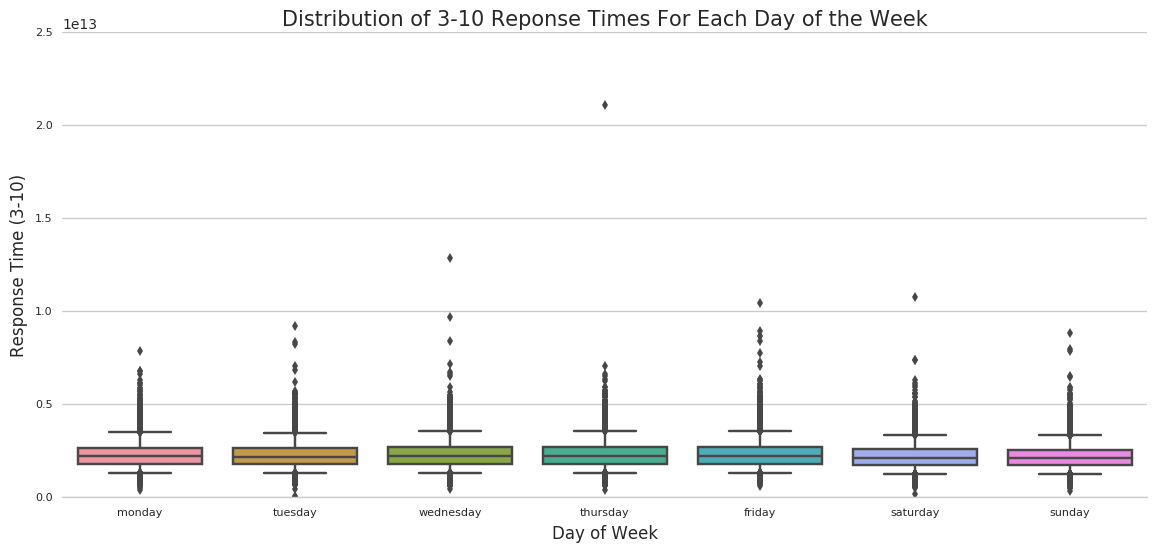

In [32]:
# boxplot of 3-10 response time for each day of week
sns.set_style("whitegrid")
plt.figure(figsize=(14,6))
bplot = sns.boxplot(x='dow', y='delta3-10', data=time_delta_clean310.replace({'dow':dow_map}), whis=[5,95])
title = 'Distribution of 3-10 Reponse Times For Each Day of the Week'
bplot.set_title(title, fontsize=15)
bplot.set_xlabel('Day of Week', fontsize=12)
bplot.set_ylabel('Response Time (3-10)', fontsize=12)
bplot.tick_params(axis='both', labelsize=8)
sns.despine(left=True) 

In [33]:
# summary stats of 3-10 response time for each month of the year
month_map = {1.0:'jan',2.0:'feb',3.0:'mar',4.0:'apr',5.0:'may',6.0:'jun',
             7.0:'jul',8.0:'aug',9.0:'sep', 10.0:'oct', 11.0:'nov', 12.0:'dec'}

time_delta_df.replace({'month':month_map}).groupby('month')['month', 'delta3-10'].describe()

delta3-10
month                              
apr   count                    3708
      mean   0 days 00:37:28.330097
      std    0 days 00:12:11.662228
      min           0 days 00:11:54
      25%           0 days 00:29:12
      50%           0 days 00:35:59
      75%           0 days 00:43:46
      max           0 days 02:53:48
aug   count                    3997
      mean   0 days 00:36:46.291218
      std    0 days 00:11:39.312274
      min         -1 days +23:58:33
      25%           0 days 00:28:31
      50%           0 days 00:35:18
      75%           0 days 00:43:09
      max           0 days 02:28:39
dec   count                    7581
      mean   0 days 00:38:19.201160
      std    0 days 00:12:03.003995
      min           0 days 00:07:08
      25%           0 days 00:29:59
      50%           0 days 00:36:52
      75%           0 days 00:44:53
      max           0 days 02:33:05
feb   count                    3421
      mean   0 days 00:37:15.664425
      std    0 days 00:11:56.607197
      min           0 days 00:09:25
      25%           0 days 00:28:58
      50%           0 days 00:36:13
...                             ...
may   std    0 days 00:11:37.640856
      min           0 days 00:06:47
      25%           0 days 00:29:17
      50%    0 days 00:36:28.500000
      75%           0 days 00:44:00
      max           0 days 01:41:18
nov   count                    7019
      mean   0 days 00:38:00.895284
      std    0 days 00:12:27.459203
      min         -1 days +23:39:35
      25%           0 days 00:29:37
      50%           0 days 00:36:51
      75%           0 days 00:44:36
      max           0 days 05:51:26
oct   count                    7494
      mean   0 days 00:37:41.408993
      std    0 days 00:11:34.161586
      min           0 days 00:00:25
      25%           0 days 00:29:27
      50%           0 days 00:36:19
      75%           0 days 00:44:17
      max           0 days 02:11:28
sep   count                    4697
      mean   0 days 00:37:45.379604
      std    0 days 00:11:42.001603
      min           0 days 00:09:45
      25%           0 days 00:29:37
      50%           0 days 00:36:09
      75%           0 days 00:44:28
      max           0 days 01:59:34

[96 rows x 1 columns]

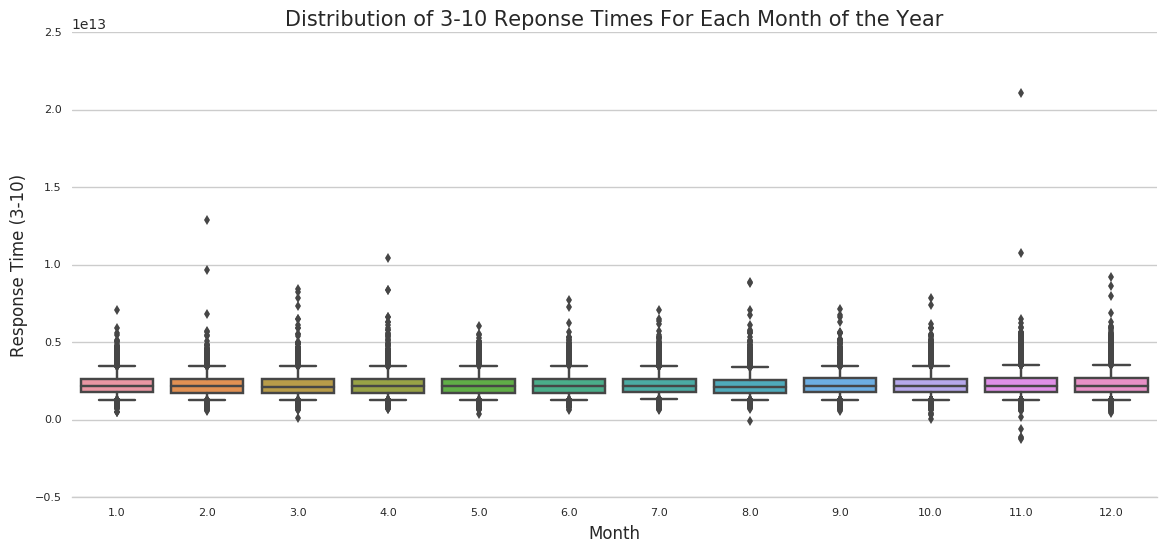

In [34]:
# boxplot of 3-10 response time by month
# decided not to map by month since it affects order of months in boxplot
sns.set_style("whitegrid")
plt.figure(figsize=(14,6))
gb_month310 = time_delta_df.groupby('month')['month', 'delta3-10']
bplot = sns.boxplot(x='month', y='delta3-10', data=time_delta_df, whis=[5,95])
title = 'Distribution of 3-10 Reponse Times For Each Month of the Year'
bplot.set_title(title, fontsize=15)
bplot.set_xlabel('Month', fontsize=12)
bplot.set_ylabel('Response Time (3-10)', fontsize=12)
bplot.tick_params(axis='both', labelsize=8)
sns.despine(left=True) 

In [35]:
# show descriptions of dispatch events as a quick reference
QUERY2='''SELECT * FROM timedesc;
  '''

In [36]:
incident_types = pquery(QUERY2)

SQL QUERY = SELECT * FROM timedesc;
  


In [37]:
incident_types

,timedesc_id,description,id_911
0,0,Received ...,None
1,1,Initiated ...,None
2,2,Entered ...,ENTRY:
3,3,Dispatched ...,DISP
4,4,Enroute ...,ENROUT
5,5,On Scene ...,ONSCNE
6,6,Fire Under Control ...,None
7,7,Close ...,CLOSE
8,8,With Patient ...,None
9,9,Depart Scene ...,None


In [38]:
conn.close()